In [2]:
# #| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# braga2024datasetname

> Module for handling the loading of bags collected with the INF-UFG car that were previously converted to the Semantic KITTI format.

In [3]:
#| default_exp braga2024datasetname

In [4]:
#| export
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch import nn
import numpy as np

In [5]:
#| export
class InfUFGDataset(Dataset):
    "Load the inf_ufg data in a pytorch Dataset object."
    def __init__(self, data_path, is_train=True, transform=None):
        data_path = Path(data_path)
        self.velodyne_path = data_path/'sequences'

        # how much sequences?
        velodyne_fns = []
        if is_train: 
            query = '*0[0-9]/velodyne/*.bin'
            velodyne_fns += list(self.velodyne_path.rglob(query))
        # validation?
        else:
            pass
    
        self.frame_ids = [fn.stem for fn in velodyne_fns]
        self.frame_sequences = [fn.parts[-3] for fn in velodyne_fns]    

        self.transform = transform
        self.is_train = is_train

    def set_transform(self, transform):
        self.transform = transform

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_sequence = self.frame_sequences[idx]
        
        frame_path = self.velodyne_path/frame_sequence/'velodyne'/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

        # Removing NAN 
        frame = frame[~np.isnan(frame).any(axis=1)]

        # Normalizing the reflectance values (which are between 0 and 255).
        frame[:,3] = frame[:,3]/255
        
        label = None
        if self.is_train:
            # The code to load the labels in the future will be here.
            pass
        
        mask = None
        if self.transform:
            frame, label, mask = self.transform(frame, label)
        
        return frame, label, mask

To use it, first download and extract the *KITTI_18-05-24* from this [link](https://drive.google.com/file/d/1hbJS4wqi1fBeg3IrL3-RilOPfGj0RrRk/view?usp=sharing) (remember to use a UFG email) into a folder called *data*, at the root of your workspace. Lastly, use the following code to get the training data in its original format:

In [6]:
#| eval: false
data_path = '/workspace/data'
ds = InfUFGDataset(data_path)
frame, label, mask = ds[128]
len(ds)

9382

Without any transform set, the data is simply read into numpy arrays and mask is set to **None**.

In [7]:
#| eval: false
frame, frame.shape

(array([[ 3.034256  ,  5.3260975 , -1.6424657 ,  0.02352941],
        [ 3.489289  ,  6.119853  , -1.6263963 ,  0.01960784],
        [ 4.1641755 ,  7.3005815 , -1.6337067 ,  0.01176471],
        ...,
        [ 7.1781106 , 11.202549  ,  2.5862253 ,  0.03921569],
        [ 6.733394  , 10.500441  ,  2.8798237 ,  0.02745098],
        [ 7.006298  , 10.917624  ,  3.4759398 ,  0.01568628]],
       dtype=float32),
 (17066, 4))

In [8]:
#| eval: false
mask == None

True

# Lidar Projections

Below, we can see the projection algorithms in action. For more detailed documentation, refer to [behley2019iccv Lidar Range Image Projections](https://air-ufg.github.io/colorcloud/behley2019iccv.html#lidar-range-image-projections)

In [9]:
#| eval: false
from colorcloud.behley2019iccv import SphericalProjection, ProjectionTransform, UnfoldingProjection, ProjectionVizTransform
from matplotlib import pyplot as plt
from torchvision.transforms import v2

Here is an example on how to use and compose the [behley2019iccv transforms](https://air-ufg.github.io/colorcloud/behley2019iccv.html#projectiontransform) with the torchvision.transforms.v2 module, and then visualize the resulting images with the matplolib.pyplot module:

In [10]:
#| eval: false
def plot_projections(img):
    fig, axs = plt.subplots(5, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        ax.set_title(title)
        ax.axis('off')

In [11]:
#| eval: false
class ProjectionVizModifiedTransform(nn.Module):
    "Pytorch transform to preprocess projection images for proper visualization."
    def __init__(self, color_map_rgb_np, learning_map_inv_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np
        self.learning_map_inv_np = learning_map_inv_np
    
    def scale(self, img, min_value, max_value):
        # assert img.max() <= max_value
        # assert img.min() >= min_value
        # assert max_value > min_value
        
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)
    
    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            r = self.scale(frame_img[:,:,3], 0., 1.)
            d = self.scale(frame_img[:,:,4], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, r, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)
        
        return normalized_frame_img, colored_label_img, mask_img

The dataset was collected with a Velodyne LiDAR PUCK-16, and the information about it can be found on this [sheet](https://www.amtechs.co.jp/product/VLP-16-Puck.pdf).

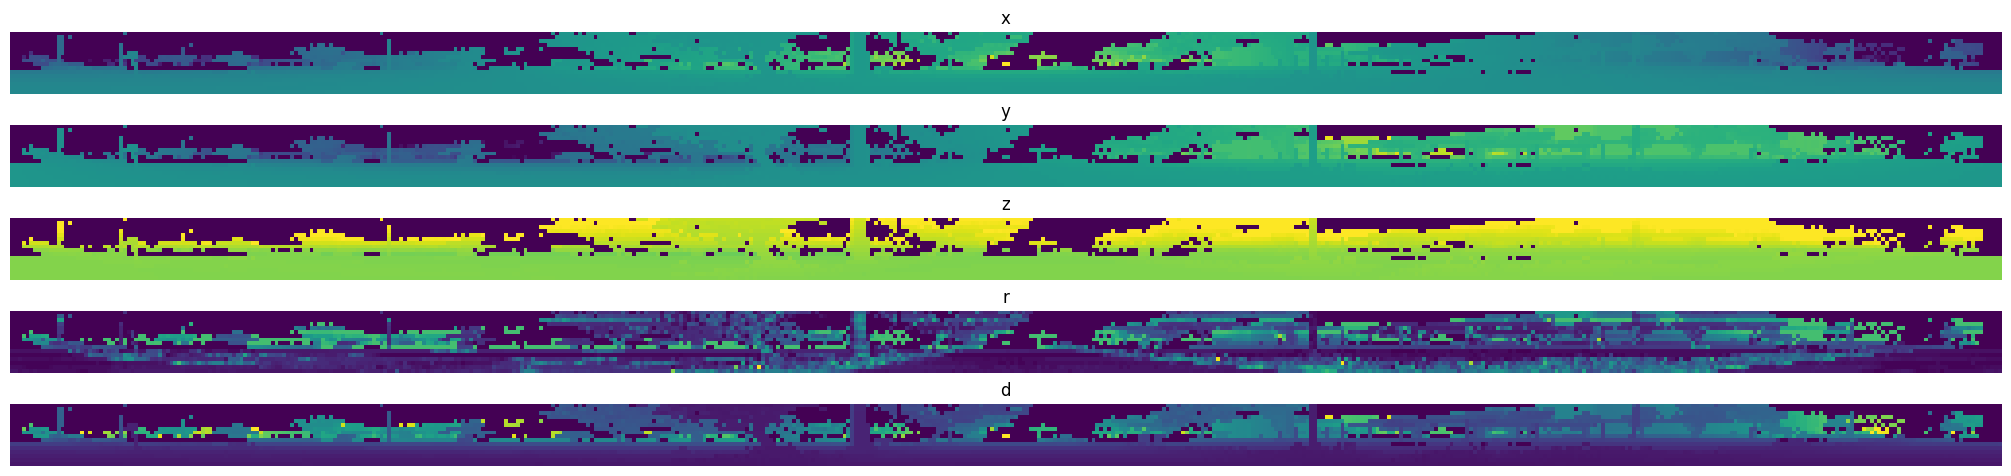

In [12]:
#| eval: false
proj = SphericalProjection(fov_up_deg=16., fov_down_deg=-16., W=512, H=16)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizModifiedTransform(color_map_rgb_np=None, learning_map_inv_np=None),
])
ds.set_transform(tfms)
img, _, _ = ds[2000]

plot_projections(img)

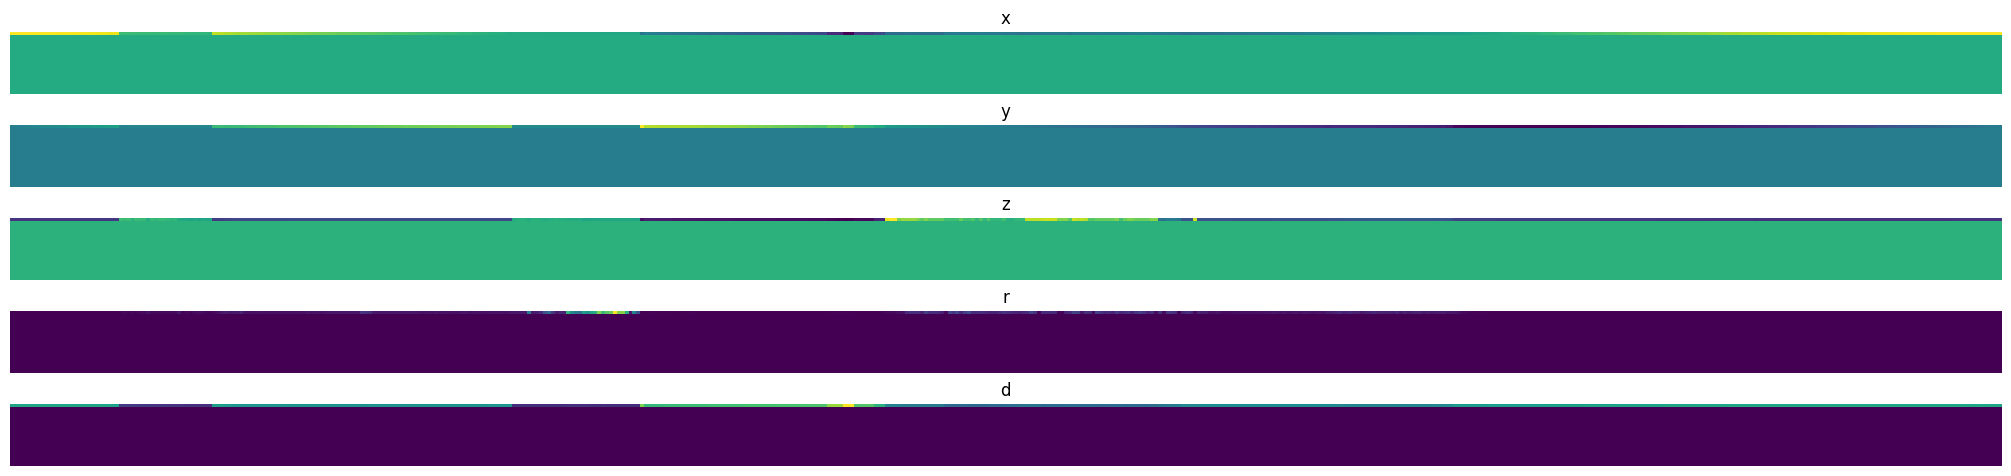

In [13]:
#| eval: false
proj = UnfoldingProjection(W=512, H=16)
tfms = v2.Compose([
    ProjectionTransform(proj),
])
ds.set_transform(tfms)
img, _, _ = ds[128]

plot_projections(img)

In the next cell, we can see how long it takes on average to sample an item from this dataset class.

In [14]:
#| eval: false
%timeit img, _, _ = ds[0]

3.26 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
#| eval: false
from colorcloud.behley2019iccv import ProjectionToTensorTransform

Just for proof of concept, since the original ProjectionToTensorTransform module isn't handling a null label.

In [16]:
#| eval: false
from torch import nn
import torch

class ProjectionToTensorFixedTransform(nn.Module):
    def forward(self, frame_img, label_img, mask_img):
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        mask_img = torch.from_numpy(mask_img)
        if label_img:
            label_img = torch.from_numpy(label_img)
        else:
            label_img = torch.zeros_like(mask_img)
        return frame_img, label_img, mask_img

Here is an example on how to use it with the spherical projection:

In [17]:
#| eval: false
proj = SphericalProjection(fov_up_deg=16., fov_down_deg=-16., W=1024, H=16)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorFixedTransform(),
])
ds.set_transform(tfms)
img, label, mask = ds[0]
print(img.shape, img.type())
print(label.shape, label.type())
print(mask.shape, mask.type())

torch.Size([5, 16, 1024]) torch.FloatTensor
torch.Size([16, 1024]) torch.BoolTensor
torch.Size([16, 1024]) torch.BoolTensor


In [18]:
#| eval: false
from torch.utils.data import DataLoader

In [19]:
#| eval: false
bs = 10
dl = DataLoader(ds, bs)
for batch in dl:
    img, label, mask = batch
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([10, 5, 16, 1024])
Shape of label 	 [N, H, W]: 	 torch.Size([10, 16, 1024])
Shape of mask 	 [N, H, W]: 	 torch.Size([10, 16, 1024])


In [20]:
#| hide
import nbdev; nbdev.nbdev_export()